# **Projet Final CNN**

Projet d'entrainement d'un modèle CNN capable de detecter les maladies des plantes avec les données de plantvillage disponible sur Kaggle

\## **Configuration et Importations**[texte du lien](https://)

Avant de pouvoir construire quoi que ce soit, nous devons importer nos **"outils"**. Chaque bibliothèque nous donne des fonctionnalités spécifiques : **TensorFlow** pour construire le réseau de neurones, **zipfile** pour décompresser nos données, et **matplotlib** pour visualiser nos résultats à la fin.

In [ ]:
# Configuration et Importations
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os

print(f"Version de TensorFlow : {tf.__version__}")

Version de TensorFlow : 2.18.0


## **Décompression des Données**

### Connecter Google Drive à Colab

In [ ]:
### Connexion à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Un modèle d'IA ne peut rien apprendre sans données. Comme vous avez téléchargé le fichier .zip sur votre machine puis l'avez importé dans Colab, cette étape consiste à extraire toutes les images de ce fichier compressé pour que notre programme puisse y accéder.

In [ ]:
print("\n--- Décompression des données depuis Google Drive ---")

# Chemin vers le fichier .zip DANS votre Google Drive
# Assurez-vous que le nom du fichier correspond bien
drive_zip_path = '/content/drive/MyDrive/Deep learning 2025/PlantVillage.zip'



--- Décompression des données depuis Google Drive ---


In [ ]:
# Décompression du fichier
with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')


In [ ]:
# On définit une variable qui pointe vers le dossier contenant toutes les images
# dans le répertoire /content de Colab
data_dir = "/content/PlantVillage"
print(f"--> Données extraites avec succès dans {data_dir}")


--> Données extraites avec succès dans /content/PlantVillage


## **Préparation et Chargement des Données**

Les données brutes ne sont pas utilisables directement. Le modèle a besoin de données propres, uniformes et organisées. Ce bloc va :

* Redimensionner toutes les images à la même taille (128x128).

* Les regrouper en "lots" (batch) pour un entraînement efficace.

* **Diviser automatiquement** toutes les images en un

jeu d'entraînement (80%) et un jeu de validation (20%).

In [ ]:
### Bloc 3 : Préparation et Chargement des Données
print("\n--- Préparation des données ---")

# Définition des paramètres
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32



--- Préparation des données ---


In [ ]:
# Création du jeu de données d'entraînement (80% des données)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Création du jeu de données de validation (20% des données)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [ ]:
# 2. On récupère les noms de classes et leur nombre ICI
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"--> {num_classes} classes trouvées.")

--> 15 classes trouvées.


In [ ]:
# 3. SEULEMENT MAINTENANT, on applique les optimisations
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## **Construction de l'Architecture du Modèle (Le Cerveau 🧠)**

C'est le cœur de notre projet. Nous définissons ici l'architecture de notre "cerveau" artificiel, couche par couche.

* **Data Augmentation** : Pour créer de la diversité et rendre le modèle plus robuste.

* **Rescaling** : Pour normaliser les pixels, une étape essentielle à l'apprentissage.

* **Conv2D / MaxPooling2D** : Les "yeux" du modèle, qui apprennent à détecter les caractéristiques visuelles des maladies.

* **Flatten / Dense / Dropout** : La partie "décisionnelle" du cerveau, qui analyse les caractéristiques vues et fait une classification finale.

In [ ]:


# Couches de Data Augmentation

### Bloc d'augmentation de données recommandé

data_augmentation = tf.keras.Sequential([
  # Simule les différents angles de prise de vue
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),

  # Simule la distance de la caméra
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),

  # Simule les déplacements de la caméra
  tf.keras.layers.RandomBrightness(0.2)
])

Ce code définit l'architecture de votre modèle de réseau de neurones, couche par couche, en utilisant l'API Sequential de Keras. C'est comme assembler les briques d'un "cerveau" artificiel.



In [ ]:

# Définition du modèle
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=IMAGE_SIZE + (3,)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

print("--> Modèle construit.")

--> Modèle construit.


## **Compilation du Modèle**

Avant de s'entraîner, le modèle a besoin d'instructions. Ce bloc lui dit :

* Comment s'améliorer (optimizer='adam').

* Comment mesurer son erreur (loss=...).

* Quelle note on lui donne (metrics=['accuracy']).

In [ ]:
### Bloc 5 : Compilation du Modèle
print("\n--- Compilation du modèle ---")

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


--- Compilation du modèle ---


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## **Entraînement du Modèle**

In [ ]:
#Entraînement du Modèle
print("\n--- Lancement de l'entraînement ---")

EPOCHS = 15
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

print("--> Entraînement terminé !")


--- Lancement de l'entraînement ---
Epoch 1/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.2728 - loss: 2.2301 - val_accuracy: 0.6072 - val_loss: 1.1528
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.5759 - loss: 1.3100 - val_accuracy: 0.6201 - val_loss: 1.1574
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.6596 - loss: 1.0296 - val_accuracy: 0.7604 - val_loss: 0.7412
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.7070 - loss: 0.8772 - val_accuracy: 0.7388 - val_loss: 0.7712
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.7302 - loss: 0.8113 - val_accuracy: 0.7398 - val_loss: 0.7771
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.7612 - loss: 0.7076 - val_accuracy: 0.8335 - val_loss: 0.4826
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.7728 - loss: 0.6618 - val_accuracy: 0.8667 - val_loss: 0.4114
Epoch 8/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 602s 1s/step - accur

In [ ]:
# Evaluation du modele
print("\n--- Evaluation du modèle ---")

test_loss, test_accuracy = model.evaluate(validation_dataset)


--- Evaluation du modèle ---
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 289ms/step - accuracy: 0.9263 - loss: 0.2370


## **Visualisation des Résultats**

Une fois l'entraînement terminé, nous devons évaluer sa performance. Ce bloc dessine des graphiques pour voir si la précision a augmenté et si la perte a diminué au fil des époques, à la fois sur les données d'entraînement et de validation. C'est le bulletin de notes de notre modèle.

In [ ]:
### Visualisation des Résultats
print("\n--- Visualisation des résultats ---")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


--- Visualisation des résultats ---


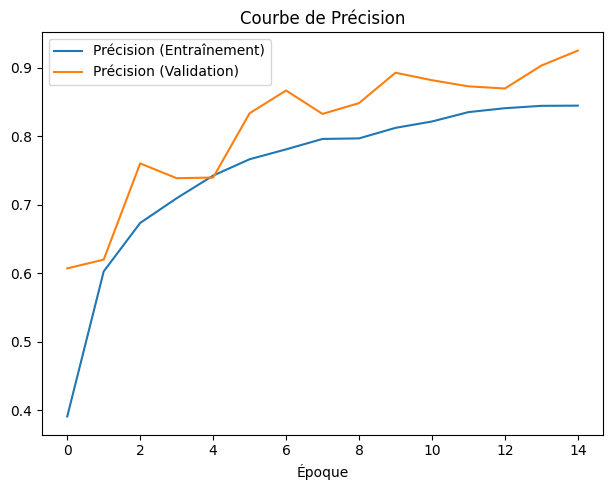

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Précision (Entraînement)')
plt.plot(val_acc, label='Précision (Validation)')
plt.legend()
plt.title('Courbe de Précision')
plt.xlabel('Époque')

plt.tight_layout()
plt.show()

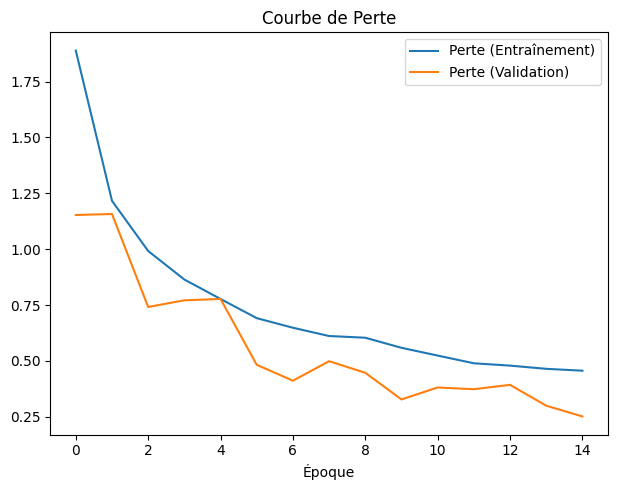

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(loss, label='Perte (Entraînement)')
plt.plot(val_loss, label='Perte (Validation)')
plt.legend()
plt.title('Courbe de Perte')
plt.xlabel('Époque')

plt.tight_layout()
plt.show()

In [ ]:
### Bloc 8 : Sauvegarde du Modèle Entraîné (Corrigé)

print("\n--- Sauvegarde du modèle ---")

# Nom du fichier avec la nouvelle extension .keras recommandée
nom_fichier_modele = 'plant_disease_model.keras'

# Sauvegarde du modèle dans le nouveau format natif
model.save(nom_fichier_modele)

print(f"--> Modèle sauvegardé avec succès dans le fichier : {nom_fichier_modele}")


--- Sauvegarde du modèle ---
--> Modèle sauvegardé avec succès dans le fichier : plant_disease_model.keras
